In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [43]:
import random
import time
import glob
import sys
import numpy as np
import collections
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout, Lambda
from tensorflow.keras.callbacks import EarlyStopping


%matplotlib inline

In [44]:
def load_data(input_size, path):
    path="te_dhena_trajnimi/foto/*.npz"
    print("Loading training data...")
    start = time.time()

    # load training data
    X = np.empty((0, input_size))
    y = np.empty((0, 4))
    training_data = glob.glob(path)

    # if no data, exit
    if not training_data:
        print("Data not found, exit")
        sys.exit()

    for single_npz in training_data:
        with np.load(single_npz) as data:
            train = data['train']
            train_labels = data['train_labels']
        X = np.vstack((X, train))
        y = np.vstack((y, train_labels))

    y = y[:, :3]
    print("Image array shape: ", X.shape)
    print("Label array shape: ", y.shape)

    end = time.time()
    print("Loading data duration: %.2fs" % (end - start))
    return X, y

In [45]:
# fix seed
tf.random.set_seed(123)
np.random.seed(123)

shape = (120, 320)
num_classes = 3
data_path ="te_dhena_trajnimi/foto/*.npz"

X, y = load_data(shape[0]*shape[1], data_path)

Loading training data...
Image array shape:  (255, 38400)
Label array shape:  (255, 3)
Loading data duration: 0.30s


In [46]:
# reshape data 
X = X.reshape(X.shape[0], shape[0], shape[1], 1)

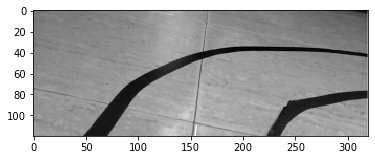

In [47]:
collections.Counter(y.argmax(-1))
plt.imshow(X[0].reshape(shape), cmap='gray')

In [136]:
model = Sequential()
model.add(Lambda(lambda x: (x/255.), input_shape=(*shape, 1)))
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
    

In [137]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_15 (Lambda)           (None, 120, 320, 1)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 116, 316, 16)      416       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 58, 158, 16)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 54, 154, 32)       12832     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 27, 77, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 25, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 12, 37, 64)      

In [138]:
model.compile(optimizer = 'adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)
checkpoint = ModelCheckpoint('model_test.h5', 
                             verbose=1, 
                             monitor='val_loss', 
                             save_best_only=True, 
                             mode='auto')
callback_list = [monitor]


In [139]:
batch_size = 16
epochs = 20

history = model.fit(X, y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.2,
          callbacks=callback_list)

Train on 204 samples, validate on 51 samples
Epoch 1/20
204/204 [==============================] - 14s 67ms/step - loss: 0.8212 - accuracy: 0.5392 - val_loss: 0.8303 - val_accuracy: 0.5098
Epoch 2/20
204/204 [==============================] - 17s 85ms/step - loss: 0.7665 - accuracy: 0.6176 - val_loss: 0.8606 - val_accuracy: 0.5098
Epoch 3/20
204/204 [==============================] - 15s 71ms/step - loss: 0.7062 - accuracy: 0.6569 - val_loss: 0.7934 - val_accuracy: 0.5098
Epoch 4/20
204/204 [==============================] - 18s 89ms/step - loss: 0.6164 - accuracy: 0.7108 - val_loss: 0.6437 - val_accuracy: 0.6078
Epoch 5/20
204/204 [==============================] - 14s 70ms/step - loss: 0.4072 - accuracy: 0.8382 - val_loss: 0.6007 - val_accuracy: 0.6471
Epoch 6/20
204/204 [==============================] - 9s 44ms/step - loss: 0.3545 - accuracy: 0.8382 - val_loss: 0.5789 - val_accuracy: 0.7059
Epoch 7/20
204/204 [==============================] - 12s 58ms/step - loss: 0.2843 - accurac

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


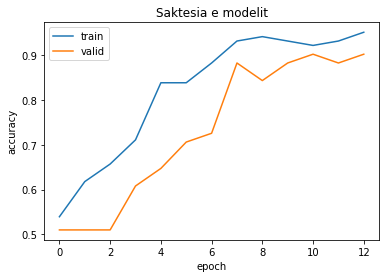

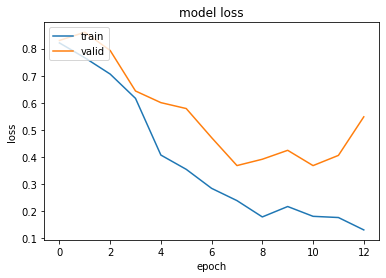

In [140]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Saktesia e modelit')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [141]:
model.save('model_test.h5')

In [142]:
from keras.models import load_model

model = load_model('model_test.h5')

In [143]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_15 (Lambda)           (None, 120, 320, 1)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 116, 316, 16)      416       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 58, 158, 16)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 54, 154, 32)       12832     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 27, 77, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 25, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 12, 37, 64)      

In [144]:
test_data_path = "training_data/*.npz"
X_test, y_test = load_data(120*320, test_data_path)

Loading training data...
Image array shape:  (255, 38400)
Label array shape:  (255, 3)
Loading data duration: 0.53s


In [145]:
X_test = X_test.reshape(X_test.shape[0], 120, 320, 1)

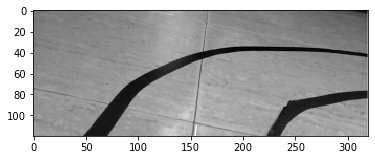

In [146]:
plt.imshow(X_test[0].reshape((120, 320)), cmap='gray')

In [148]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = model.predict_classes(X_test)
y_true = np.argmax(y_test, -1)

print(y_pred)
print(y_true)
print(accuracy_score(y_true, y_pred))
print()
print("Confusion Matrix")
print(confusion_matrix(y_true, y_pred))

[1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 1 1
 1 1 1 1 2 2 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 1
 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 2 2 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 1
 1 1 1 1 1 1 1 0 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 1 2 1 1 1
 1 1 1 1 2 2 1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2